#Mount and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Sep 21 13:15:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers==4.2.1
!pip install farasapy
!pip install pyarabic
!pip install sentencepiece
!git clone https://github.com/aub-mind/arabert

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 2.9 MB 34.2 MB/s 
     |████████████████████████████████| 126 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 544, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 544 (delta 175), reused 237 (delta 87), pack-reused 214
Receiving objects: 100% (544/544), 9.15 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [4]:
import pandas as pd
import numpy as np
import re

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from arabert.preprocess import ArabertPreprocessor
import transformers
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix
%matplotlib inline

#Pandas Viewing presets

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('display.max_rows', None)
# pd.options.display.max_colwidth = 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
pd.reset_option('^display.', silent=True)

#Data Exploration

In [ ]:
arabic_train = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Train.txt',sep='\t')
arabic_dev = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Dev.txt',sep='\t')
arabic_test = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Test.txt',sep='\t')

In [ ]:
# Get the max_len/ avg_len of the tokenized corpus.
texts = arabic_train.Arabic.values
x = TOKENIZER.batch_encode_plus(texts)['input_ids']
max_len = 0
sum = 0
for i in x:
  sum+=len(i)
  if len(i) > max_len:
    max_len = len(i)
print(f"max_len: {max_len}, average_len: {sum/len(x)}")

In [55]:
"""
Using the original ptc-corpus for propaganda to translate to arabic.
This code is meant to get the seperate articles with their labels and join them
into a single dataframe. 
"""
from os import listdir
from os.path import isfile, join

def get_file_names_in_dir(mypath):
  return [f for f in listdir(mypath) if isfile(join(mypath, f))]

def get_data(text_path, label_path, test=False):

  df = pd.DataFrame(columns=['id','text'])
  files = get_file_names_in_dir(text_path)
  for idx, f in tqdm(enumerate(files),total=len(files), desc = 'getting text...'):
    txt = Path(text_path+'/'+f).read_text()
    # txt = txt.replace('\n', '')
    id = re.findall('\d+', f)[0]
    df = df.append({'id':id,'text':txt}, ignore_index=True)
  df.sort_values(by = ['id'],inplace=True)
  if test:
    return df
  main_df = pd.DataFrame(columns = ['id', 'text_span', 'label'])
  files = get_file_names_in_dir(label_path)
  for idx, f in tqdm(enumerate(files), total = len(files), desc = 'attaching labels to text'): #looping over the label files
    temp_df = pd.read_csv(label_path+'/'+f, sep = '\t',  names = ['id','prop','start','end'])
    for idx, row in temp_df.iterrows(): #looping over a single label file
      id = str(row['id'])
      text = df.loc[df['id'] == id].text.values[0][row['start']:row['end']]
      label = row['prop']
      main_df = main_df.append(
          {'id':id, 'text_span':text, 'label':label},
          ignore_index=True,
      )
  return main_df


# label_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/train-labels-task-flc-tc/'
# text_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/train-articles'
# train = get_data(text_path=text_path, label_path=label_path)

# label_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/dev-labels-task-flc-tc'
# text_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/dev-articles'
# dev = get_data(text_path=text_path, label_path=label_path)

# train.to_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/Processed/train.csv',index=False)
# dev.to_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/Processed/dev.csv',index=False)

In [56]:
text_path = '/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Raw-articles/test-articles'
test = get_data(text_path=text_path, label_path='', test=True)

getting text...:   0%|          | 0/90 [00:00<?, ?it/s]

In [58]:
test.sort_values(by=['id'])

id                                               text
86  813452859  EU Profits From Trading With UK While London L...
44  813494037  Sadiq Khan Slammed for Pro-EU 'Message of Supp...
64  813547724  Foreign Secretary Jeremy Hunt says the UK shou...
25  813552066  You insult us, ambassador: Woody Johnson flagr...
60  813601978  Big Apple joins in ringing in New Year after r...
..        ...                                                ...
23  833050243  Mueller Report: 'US Forced EU to Follow Throug...
56  833052347  US reacts to end of Mueller probe with relief,...
27  833053628  Confident Trump and anxious Washington wait fo...
13  833053676  Dem Rep. Lewis on Trump Impeachment Post-Muell...
34  833067493  Don Trump Jr uses Maury Povich paternity meme ...

[90 rows x 2 columns]

#Utility

##Dataset class and functions

In [7]:
class Dataset:
  """
  Class Dataset used to create an iterable version of the dataset with the
  ability to return the text tokenized upon indexing.

  An object of this class can be treated as a list object. Indexing with this 
  object (ex: dataset[idx] ) will return a dictionary. 
  """
  def __init__(self, text, target, tokenizer):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = config['MAX_LEN']

  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    text = str(self.text[item])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation='longest_first'
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs['token_type_ids']

    return {
        "ids": torch.tensor(ids, dtype=torch.long),
        "mask": torch.tensor(mask, dtype=torch.long),
        "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        "targets": torch.tensor(self.target[item], dtype=torch.float),
    }

In [8]:
def loss_fn(outputs, targets):
  """ 
  Loss function to claculate loss. Loss measure used is the Binary-Cross-
  Entropy.
  """
  return nn.BCEWithLogitsLoss()(outputs, targets)

def train_fn(data_loader, model, optimizer, device, scheduler):
  """
  Training function. Accepts a torch.dataLoader object, the model to be trained,
  the optimizer, the device to be trained on (ex: Cuda) and finally a scheduler
  for the optimizer.

  The dataLoader is used to iterate over the batches of the training data.
  Performs forward and backprop on the model and saves the weights.
  """
  model.train()

  for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
    ids = d["ids"]
    token_type_ids = d["token_type_ids"]
    mask = d["mask"]
    targets = d["targets"]

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()

def eval_fn(data_loader, model, device):
  """
  Similar to the training function but the model is in evaluation mode (model 
  layers are frozen).

  Performs forward-prop on the model with the validation data.
  Returns the model predictions as well as the data gold labels.
  """
  model.eval()
  fin_targets = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
      ids = d["ids"]
      token_type_ids = d["token_type_ids"]
      mask = d["mask"]
      targets = d["targets"]

      ids = ids.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      mask = mask.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

##Preprocessing Code

In [9]:
def MapLabels(df):
  """
  Function to preprocess data.
  Removes unwanted datasamples according to specific labels.
  Creates a one-hot-encoded version of the labels. 
  """
  onehot_col = []
  df.drop(df.loc[df['label']=='Repetition'].index, inplace=True)
  df.drop(df.loc[df['label']=='Bandwagon'].index, inplace=True)
  df.drop(df.loc[df['label']=='Straw_Men'].index, inplace=True)
  df.drop(df.loc[df['label']=='Whataboutism'].index, inplace=True)
  df.drop(df.loc[df['label']=='Reductio_ad_hitlerum'].index, inplace=True)
  df.drop(df.loc[df['label']=='Red_Herring'].index, inplace=True)
  df.drop(df.loc[df['label']=='Obfuscation,Intentional_Vagueness,Confusion'].index, inplace=True)
  df.drop(df.loc[df['label']=='Thought-terminating_Cliches'].index, inplace=True)

  map = {
      'Slogans':0,
      'Black-and-White_Fallacy':1,
      'Loaded_Language':2,
      'Flag-Waving':3,
      'Name_Calling':4,
      'Labeling':5,
      'Causal_Oversimplification':6,
      'Exaggeration':7,
      'Minimisation':8,
      'Doubt':9,
      'Appeal_to_Authority':10,
      'Appeal_to_fear-prejudice':11,
  }

  for idx,row in df.iterrows():
    temp = re.split(',',df.label[idx])
    label = []
    onehot = [0] * 12
    for l in temp:
      label.append(map[l])
    for i in label:
      onehot[i] = 1
    onehot_col.append(onehot) 
  df['oneHot'] = onehot_col
  return df

##Trainer Code

In [10]:
def Run(train, dev, text_col_name):
  """
  Main runner code to finetune model. Saves model weights on each epoch if the 
  model score is higher than before.
  """
  train = MapLabels(train)
  dev = MapLabels(dev)
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    dev[text_col_name] = dev[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['oneHot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=dev[text_col_name].values,
      target=dev['oneHot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  device = torch.device(config['DEVICE'])
  model = Model()
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.0,
      },
  ]

  num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * config['EPOCHS'])
  optimizer = AdamW(optimizer_parameters, lr=config['LEARNING_RATE'])
  scheduler = get_linear_schedule_with_warmup(
      optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
  )

  best_score = 0
  performance = []
  for epoch in range(config['EPOCHS']):
    train_fn(train_data_loader, model, optimizer, device, scheduler)
    outputs, targets = eval_fn(valid_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_samples = metrics.f1_score(targets, outputs,average='samples')
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    f1_macro = metrics.f1_score(targets, outputs,average='macro')
    accuracy = metrics.accuracy_score(targets, outputs)
    print(f"<---------------Epoch {epoch+1}--------------->")
    print(f"f1-Samples Score = {f1_samples}")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"f1-Macro Score = {f1_macro}")
    print(f"Accuracy Score = {accuracy}")
    epoch_performance = {'Epoch': epoch,
                         'F1-Samples':f1_samples,
                         'F1-Micro':f1_micro,
                         'F1-Macro':f1_macro,
                         'Accuracy':accuracy}
    performance.append(epoch_performance)
    if f1_micro > best_score:
      print("Saving model...")
      torch.save(model.state_dict(), config['MODEL_PATH'])
      best_score = f1_micro
  return performance

##Evaluation Code

In [11]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
  """
  Function to print confusion matrix for labels.
  """
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names,
  )

  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  axes.set_ylabel('True label')
  axes.set_xlabel('Predicted label')
  axes.set_title(class_label)

##Hyperparameter Tuning

In [12]:
def TuneLearningRate(model_name, train, dev, test, text_col_name, low_lr=1e-5, high_lr=9e-3, epochs=5):
  path = f"/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Tuning/"
  train = MapLabels(train)
  dev = MapLabels(dev)
  test = MapLabels(test)
  print(f"Model: {config['MODEL_ID']}")
  if config['ArabertPreprocessor']:
    print("Using the Arabert Pre-processor")
    arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
    train[text_col_name] = train[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    dev[text_col_name] = dev[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
    test[text_col_name] = test[text_col_name].apply(lambda x:  arabert_prep.preprocess(x))
  else:
    print("Not using the Arabert Pre-processor")

  train_dataset = Dataset(
      text=train[text_col_name].values,
      target=train['oneHot'].values,
      tokenizer = TOKENIZER
  )

  train_data_loader = DataLoader(
      train_dataset, batch_size=config['TRAIN_BATCH_SIZE'], num_workers=2
  )

  valid_dataset = Dataset(
      text=dev[text_col_name].values,
      target=dev['oneHot'].values,
      tokenizer = TOKENIZER
  )

  valid_data_loader = DataLoader(
      valid_dataset, batch_size=config['VALID_BATCH_SIZE'], num_workers=1
  )

  test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['oneHot'].values,
      tokenizer = TOKENIZER
  )

  test_data_loader = DataLoader(
      test_dataset, batch_size=1, num_workers=1
  )

  global_score = 0
  best_lr = 0
  device = torch.device(config['DEVICE'])
  performance_for_lrs = []
  lr = 1
  decimal = low_lr
  
  while (lr * decimal) < high_lr:
    current_learning_rate = lr * decimal
    lr+=1
    if lr == 10:
      decimal *= 10
      lr = 1
    
    model = Model()
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    num_train_steps = int(len(train) / config['TRAIN_BATCH_SIZE'] * epochs)
    optimizer = AdamW(optimizer_parameters, lr=current_learning_rate)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    best_score = 0
    print("##################################################")
    print("##################################################\n")
    for epoch in range(epochs):
      train_fn(train_data_loader, model, optimizer, device, scheduler)
      outputs, targets = eval_fn(valid_data_loader, model, device)
      outputs = np.array(outputs) >= 0.5
      f1_micro = metrics.f1_score(targets, outputs,average='micro')
      accuracy = metrics.accuracy_score(targets, outputs)

      print(f"<---------------Epoch {epoch+1}--------------->")
      print(f"f1-Micro Score = {f1_micro}")
      print(f"Accuracy Score = {accuracy}")

      if f1_micro > best_score:
        best_score = f1_micro
        print("Saving model...")
        torch.save(model.state_dict(), path+f'{model_name}.bin')
    
    model.load_state_dict(torch.load(path+f'{model_name}.bin'))
    outputs, targets = eval_fn(test_data_loader, model, device)
    outputs = np.array(outputs) >= 0.5
    f1_micro = metrics.f1_score(targets, outputs,average='micro')
    accuracy = metrics.accuracy_score(targets, outputs)
    
    print(f"\n<---------------Test Set Performance--------------->")
    print(f"f1-Micro Score = {f1_micro}")
    print(f"Accuracy Score = {accuracy}")
    print(f"Current lr: {current_learning_rate}")
    print(f"Local_Score on training data: {best_score}")
    temp_dict = {
        'learning_rate':current_learning_rate,
        'Accuracy':accuracy,
        'f1-micro':f1_micro,
    }
    performance_for_lrs.append(temp_dict)
    if f1_micro > global_score:
      print(f"\nChanging global score...")
      print(f"Old Global score: {global_score} with lr={current_learning_rate}")
      global_score = f1_micro
      best_lr = current_learning_rate
      print(f"Global score now: {global_score}, lr={best_lr}")
      print("Saving model...")
      torch.save(model.state_dict(), path+f'{model_name}_final_model.bin')
      best_score = f1_micro
    del model
    print('\n\n')
  
  print(f"\nGlobal_score: {global_score}")
  print(f"Best lr: {best_lr}")

  temp_dict = {
      'Best_LEARNING_RATE':best_lr,
      'Score':global_score,
  }
  performance_for_lrs.append(temp_dict)
  return performance_for_lrs

## Translation

##Model Class

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config['MODEL_ID'], return_dict=False)
        
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(config['HIDDEN_SIZE'], config['NUM_LABELS'])

    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

#Config

In [14]:
"""
aubmindlab/bert-base-arabertv02
asafaya/bert-base-arabic
kuisailab/albert-base-arabic
UBC-NLP/ARBERT
UBC-NLP/MARBERT
"""

config = {
    'MODEL_ID': "aubmindlab/bert-base-arabertv02",
    'HIDDEN_SIZE': 768,
    'DEVICE': "cuda",
    'MAX_LEN': 200,

    'TRAIN_BATCH_SIZE': 32,
    'VALID_BATCH_SIZE': 16,

    'EPOCHS': 10,
    'LEARNING_RATE': 3e-5,

    'MODEL_PATH': "/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/model.bin",
    'NUM_LABELS': 12,
    'ArabertPreprocessor': True,
  }
performance = {}
TOKENIZER = transformers.BertTokenizer.from_pretrained(config['MODEL_ID'])

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

#Tuning

In [ ]:
path = r'/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/'

train = pd.read_csv(path+'Data/Arabic-Data/Train.txt', sep='\t')
dev = pd.read_csv(path+'Data/Arabic-Data/Dev.txt', sep='\t')
test = pd.read_csv(path+'Data/Arabic-Data/Test.txt', sep='\t')

tuning_report = {}
tuning_report['MODEL_ID'] = config['MODEL_ID']
tuning_report['report'] = TuneLearningRate(model_name='MARBERT',
                                           train=train,
                                           dev=dev,
                                           test=test,
                                           text_col_name='Arabic',
                                           epochs=8,
                                           low_lr=1e-5,
                                           high_lr=5e-3)
with open(path+'Tuning/tuning_report.json', 'w') as fp:
    json.dump(tuning_report, fp)

Model: aubmindlab/bert-base-arabertv02
Using the Arabert Pre-processor
##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.2730989370400654
Accuracy Score = 0.19845360824742267
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5672009864364982
Accuracy Score = 0.4368556701030928
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.5884498480243161
Accuracy Score = 0.4677835051546392
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.5904059040590406
Accuracy Score = 0.4742268041237113
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6078665077473182
Accuracy Score = 0.4896907216494845
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6154754873006497
Accuracy Score = 0.5
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.619500594530321
Accuracy Score = 0.5012886597938144
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.614921780986763
Accuracy Score = 0.49742268041237114


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5569416498993964
Accuracy Score = 0.4550898203592814
Current lr: 1e-05
Local_Score on training data: 0.619500594530321

Changing global score...
Old Global score: 0 with lr=1e-05
Global score now: 0.5569416498993964, lr=1e-05
Saving model...



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5118110236220472
Accuracy Score = 0.39948453608247425
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6129411764705882
Accuracy Score = 0.49871134020618557
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.645198389879241
Accuracy Score = 0.5463917525773195
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6569178852643419
Accuracy Score = 0.5682989690721649
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6670305676855894
Accuracy Score = 0.5824742268041238
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6557911908646002
Accuracy Score = 0.5773195876288659


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6518353726362625
Accuracy Score = 0.5695876288659794


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6545247581104155
Accuracy Score = 0.5670103092783505


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5675576711827169
Accuracy Score = 0.5029940119760479
Current lr: 2e-05
Local_Score on training data: 0.6670305676855894

Changing global score...
Old Global score: 0.5569416498993964 with lr=2e-05
Global score now: 0.5675576711827169, lr=2e-05
Saving model...



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.4855428259683579
Accuracy Score = 0.38273195876288657
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6056419113413932
Accuracy Score = 0.5051546391752577
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6433013001695873
Accuracy Score = 0.5592783505154639
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6545454545454547
Accuracy Score = 0.5850515463917526
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6609534011783611
Accuracy Score = 0.5850515463917526
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6497797356828194
Accuracy Score = 0.586340206185567


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6496390893947808
Accuracy Score = 0.5824742268041238


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6478092068774265
Accuracy Score = 0.586340206185567


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5667987036370185
Accuracy Score = 0.5115483319076134
Current lr: 3.0000000000000004e-05
Local_Score on training data: 0.6609534011783611



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5688073394495413
Accuracy Score = 0.4639175257731959
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6382271468144044
Accuracy Score = 0.5476804123711341
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6550951847704368
Accuracy Score = 0.586340206185567
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6426623022367702
Accuracy Score = 0.5979381443298969


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6601836844948678
Accuracy Score = 0.6121134020618557
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6582417582417582
Accuracy Score = 0.6134020618556701


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6670276123443422
Accuracy Score = 0.6185567010309279
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6582832148715144
Accuracy Score = 0.604381443298969


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6132177681473456
Accuracy Score = 0.5774165953806673
Current lr: 4e-05
Local_Score on training data: 0.6670276123443422

Changing global score...
Old Global score: 0.5675576711827169 with lr=4e-05
Global score now: 0.6132177681473456, lr=4e-05
Saving model...



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5758293838862559
Accuracy Score = 0.47809278350515466
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6161504424778761
Accuracy Score = 0.5219072164948454
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6477516059957173
Accuracy Score = 0.5786082474226805
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6471544715447155
Accuracy Score = 0.5850515463917526


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6494623655913978
Accuracy Score = 0.6030927835051546
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6547231270358307
Accuracy Score = 0.6146907216494846
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6486193827828911
Accuracy Score = 0.6005154639175257


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6469321851453175
Accuracy Score = 0.6069587628865979


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6087580760947594
Accuracy Score = 0.5765611633875107
Current lr: 5e-05
Local_Score on training data: 0.6547231270358307



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.49211356466876977
Accuracy Score = 0.4110824742268041
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6328976034858388
Accuracy Score = 0.5515463917525774
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6436024162548051
Accuracy Score = 0.5605670103092784
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6370614035087719
Accuracy Score = 0.5837628865979382


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6505263157894737
Accuracy Score = 0.6108247422680413
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6680828465215082
Accuracy Score = 0.6211340206185567
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6506410256410257
Accuracy Score = 0.6056701030927835


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.651336898395722
Accuracy Score = 0.6134020618556701


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6055045871559632
Accuracy Score = 0.5782720273738238
Current lr: 6.000000000000001e-05
Local_Score on training data: 0.6680828465215082



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5093833780160858
Accuracy Score = 0.4252577319587629
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6541956173169429
Accuracy Score = 0.5837628865979382
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6386192017259978
Accuracy Score = 0.5747422680412371


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.635740643120717
Accuracy Score = 0.5902061855670103


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6451612903225806
Accuracy Score = 0.6134020618556701


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6341463414634145
Accuracy Score = 0.6030927835051546


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6407249466950959
Accuracy Score = 0.6056701030927835


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6340677055346589
Accuracy Score = 0.595360824742268


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5659683939728041
Accuracy Score = 0.5021385799828914
Current lr: 7.000000000000001e-05
Local_Score on training data: 0.6541956173169429



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5383817427385892
Accuracy Score = 0.4832474226804124
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6118671747414262
Accuracy Score = 0.5180412371134021
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6313489896231568
Accuracy Score = 0.5708762886597938
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6547179757511861
Accuracy Score = 0.6018041237113402
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6476190476190475
Accuracy Score = 0.6082474226804123


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6450584484590862
Accuracy Score = 0.6082474226804123


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.64
Accuracy Score = 0.5992268041237113


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6351423965609888
Accuracy Score = 0.5979381443298969


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5990750622554251
Accuracy Score = 0.5560307955517536
Current lr: 8e-05
Local_Score on training data: 0.6547179757511861



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.5081466395112016
Accuracy Score = 0.43170103092783507
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.6341207349081366
Accuracy Score = 0.5721649484536082
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6449237243556023
Accuracy Score = 0.5940721649484536
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.6595631326584975
Accuracy Score = 0.6030927835051546
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.6680919294494923
Accuracy Score = 0.6262886597938144
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.6592709984152141
Accuracy Score = 0.625


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.6492537313432837
Accuracy Score = 0.6121134020618557


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.6473429951690822
Accuracy Score = 0.6134020618556701


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.6043680630146795
Accuracy Score = 0.5748502994011976
Current lr: 9e-05
Local_Score on training data: 0.6680919294494923



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.29558541266794625
Accuracy Score = 0.19974226804123713
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.5524673851389676
Accuracy Score = 0.452319587628866
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.6132748217224355
Accuracy Score = 0.5244845360824743
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5078769692423106
Accuracy Score = 0.4354148845166809
Current lr: 0.0001
Local_Score on training data: 0.6132748217224355



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.5078769692423106
Accuracy Score = 0.4354148845166809
Current lr: 0.0002
Local_Score on training data: 0



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876
Saving model...


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.00030000000000000003
Local_Score on training data: 0.34023503077784



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876
Saving model...


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0004
Local_Score on training data: 0.34023503077784



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0005
Local_Score on training data: 0



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0006000000000000001
Local_Score on training data: 0



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876
Saving model...


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0007
Local_Score on training data: 0.34023503077784



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0008
Local_Score on training data: 0



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.0009000000000000001
Local_Score on training data: 0.34023503077784



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Micro Score = 0.34023503077784
Accuracy Score = 0.3917525773195876
Saving model...


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Micro Score = 0.0
Accuracy Score = 0.0


  0%|          | 0/1169 [00:00<?, ?it/s]


<---------------Test Set Performance--------------->
f1-Micro Score = 0.32739674118984463
Accuracy Score = 0.369546621043627
Current lr: 0.001
Local_Score on training data: 0.34023503077784



##################################################
##################################################



  0%|          | 0/139 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Training Code

In [61]:
data_path = r'/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Translated-data/'

train = pd.read_csv(data_path+'train.csv')
dev = pd.read_csv(data_path+'dev.csv')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Train.txt',sep='\t')
dev = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Dev.txt',sep='\t')

model_performance = Run(train=train, dev=dev, text_col_name='Arabic')
performance['MODEL_EPOCHS'] = model_performance

with open('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/config.json', 'w') as fp:
    json.dump(config, fp)
with open('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Epochs.json', 'w') as fp:
    json.dump(performance, fp)

Using the Arabert Pre-processor


Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 1--------------->
f1-Samples Score = 0.3887457044673539
f1-Micro Score = 0.43888070692194403
f1-Macro Score = 0.1806030802265343
Accuracy Score = 0.3853092783505155
Saving model


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 2--------------->
f1-Samples Score = 0.4948453608247423
f1-Micro Score = 0.552178318135765
f1-Macro Score = 0.29022494072189065
Accuracy Score = 0.49226804123711343
Saving model


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 3--------------->
f1-Samples Score = 0.5342783505154639
f1-Micro Score = 0.588421052631579
f1-Macro Score = 0.32621154752030074
Accuracy Score = 0.529639175257732
Saving model


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 4--------------->
f1-Samples Score = 0.5730240549828178
f1-Micro Score = 0.6127839408346539
f1-Macro Score = 0.37053371636478816
Accuracy Score = 0.5721649484536082
Saving model


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 5--------------->
f1-Samples Score = 0.5627147766323024
f1-Micro Score = 0.6048257372654156
f1-Macro Score = 0.38680097176088984
Accuracy Score = 0.5618556701030928


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 6--------------->
f1-Samples Score = 0.5770618556701032
f1-Micro Score = 0.6113490364025697
f1-Macro Score = 0.4048752918709939
Accuracy Score = 0.5734536082474226


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 7--------------->
f1-Samples Score = 0.5798969072164949
f1-Micro Score = 0.6110812264658418
f1-Macro Score = 0.4024553023381238
Accuracy Score = 0.5798969072164949


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 8--------------->
f1-Samples Score = 0.5905927835051545
f1-Micro Score = 0.6104712041884817
f1-Macro Score = 0.42560856125148444
Accuracy Score = 0.5837628865979382


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 9--------------->
f1-Samples Score = 0.5805412371134021
f1-Micro Score = 0.5994666666666665
f1-Macro Score = 0.4274487240638703
Accuracy Score = 0.5798969072164949


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 10--------------->
f1-Samples Score = 0.5979381443298969
f1-Micro Score = 0.6215932914046122
f1-Macro Score = 0.5079741482317541
Accuracy Score = 0.595360824742268
Saving model


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 11--------------->
f1-Samples Score = 0.5897766323024055
f1-Micro Score = 0.5991561181434598
f1-Macro Score = 0.46338327592509726
Accuracy Score = 0.5889175257731959


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 12--------------->
f1-Samples Score = 0.593213058419244
f1-Micro Score = 0.6112852664576803
f1-Macro Score = 0.4860077652066837
Accuracy Score = 0.5902061855670103


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 13--------------->
f1-Samples Score = 0.5771048109965635
f1-Micro Score = 0.5875647668393783
f1-Macro Score = 0.46397917646237685
Accuracy Score = 0.5747422680412371


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 14--------------->
f1-Samples Score = 0.5985395189003435
f1-Micro Score = 0.6139438085327784
f1-Macro Score = 0.4645511245062945
Accuracy Score = 0.5940721649484536


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 15--------------->
f1-Samples Score = 0.6140034364261168
f1-Micro Score = 0.6188247529901196
f1-Macro Score = 0.4791944578374124
Accuracy Score = 0.6069587628865979


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 16--------------->
f1-Samples Score = 0.5809278350515464
f1-Micro Score = 0.5931677018633541
f1-Macro Score = 0.4591552867959477
Accuracy Score = 0.5798969072164949


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 17--------------->
f1-Samples Score = 0.5811426116838487
f1-Micro Score = 0.6012591815320042
f1-Macro Score = 0.45638002008939466
Accuracy Score = 0.5734536082474226


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 18--------------->
f1-Samples Score = 0.5753006872852233
f1-Micro Score = 0.5912677538137823
f1-Macro Score = 0.44558692577656694
Accuracy Score = 0.5708762886597938


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 19--------------->
f1-Samples Score = 0.5725945017182129
f1-Micro Score = 0.5801366263794009
f1-Macro Score = 0.44909231277738
Accuracy Score = 0.5682989690721649


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 20--------------->
f1-Samples Score = 0.5957903780068728
f1-Micro Score = 0.605427974947808
f1-Macro Score = 0.4870906408417546
Accuracy Score = 0.5940721649484536


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 21--------------->
f1-Samples Score = 0.5989690721649484
f1-Micro Score = 0.6045785639958376
f1-Macro Score = 0.48178119267842695
Accuracy Score = 0.595360824742268


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 22--------------->
f1-Samples Score = 0.5796391752577319
f1-Micro Score = 0.586171310629515
f1-Macro Score = 0.4582567459912547
Accuracy Score = 0.5760309278350515


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 23--------------->
f1-Samples Score = 0.5801116838487973
f1-Micro Score = 0.5890760592138846
f1-Macro Score = 0.46348022494571284
Accuracy Score = 0.5786082474226805


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 24--------------->
f1-Samples Score = 0.5813144329896908
f1-Micro Score = 0.5903307888040712
f1-Macro Score = 0.46646000476312643
Accuracy Score = 0.5747422680412371


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 25--------------->
f1-Samples Score = 0.568041237113402
f1-Micro Score = 0.578512396694215
f1-Macro Score = 0.45274522813353335
Accuracy Score = 0.5644329896907216


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 26--------------->
f1-Samples Score = 0.57856529209622
f1-Micro Score = 0.5957230142566191
f1-Macro Score = 0.4590287341224824
Accuracy Score = 0.5760309278350515


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 27--------------->
f1-Samples Score = 0.5852233676975945
f1-Micro Score = 0.5950668036998973
f1-Macro Score = 0.4597631083254154
Accuracy Score = 0.5811855670103093


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 28--------------->
f1-Samples Score = 0.5731958762886598
f1-Micro Score = 0.5857868020304567
f1-Macro Score = 0.44282850912577776
Accuracy Score = 0.5657216494845361


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 29--------------->
f1-Samples Score = 0.5764604810996564
f1-Micro Score = 0.5835897435897436
f1-Macro Score = 0.4542083486229378
Accuracy Score = 0.5657216494845361


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<---------------Epoch 30--------------->
f1-Samples Score = 0.5905498281786942
f1-Micro Score = 0.5948979591836735
f1-Macro Score = 0.46709974712095587
Accuracy Score = 0.5837628865979382


  0%|          | 0/247 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#Testing Code

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/Data/Arabic-Data/Test.txt',sep='\t')
test= MapLabels(test)
if config['ArabertPreprocessor']:
  arabert_prep= ArabertPreprocessor("aubmindlab/bert-base-arabertv02".split("/")[-1])
  test['Arabic'] = test['Arabic'].apply(lambda x:  arabert_prep.preprocess(x))

model = Model()
model.load_state_dict(torch.load(config['MODEL_PATH']))
model.eval()
device = torch.device(config['DEVICE'])
model.to(device)

test_dataset = Dataset(
      text=test['Arabic'].values,
      target=test['oneHot'].values,
      tokenizer = TOKENIZER
  )

test_data_loader = DataLoader(
    test_dataset, batch_size=1, num_workers=1
)
outputs, targets = eval_fn(test_data_loader, model, device)
outputs = np.array(outputs) >= 0.5
f1 = metrics.f1_score(targets, outputs,average='samples')
f1_micro = metrics.f1_score(targets, outputs,average='micro')
f1_macro = metrics.f1_score(targets, outputs,average='macro')
accuracy = metrics.accuracy_score(targets, outputs)
print(f"<---------------Test Set Performance--------------->")
print(f"f1-Samples Score = {f1}")
print(f"f1-Micro Score = {f1_micro}")
print(f"f1-Macro Score = {f1_macro}")
print(f"Accuracy Score = {accuracy}")

  0%|          | 0/1169 [00:00<?, ?it/s]

<---------------Test Set Performance--------------->
f1-Samples Score = 0.5665526090675791
f1-Micro Score = 0.582006920415225
f1-Macro Score = 0.4422912653182396
Accuracy Score = 0.5637296834901625


model name:  UBC-NLP/MARBERT 
Arabert_Prep: True 
Accuracy:  0.5637296834901625

                           precision    recall  f1-score   support

                  Slogans     0.4545    0.2778    0.3448        36
  Black-and-White_Fallacy     0.3333    0.0400    0.0714        25
          Loaded_Language     0.7311    0.7616    0.7460       432
              Flag-Waving     0.8750    0.5444    0.6712        90
             Name_Calling     0.6615    0.6077    0.6334       209
                 Labeling     0.6579    0.5981    0.6266       209
Causal_Oversimplification     0.6364    0.2188    0.3256        32
             Exaggeration     0.3586    0.5652    0.4388        92
             Minimisation     0.3611    0.5652    0.4407        92
                    Doubt     0.5439    0.4306    0.4806        72
      Appeal_to_Authority     0.2667    0.0755    0.1176        53
 Appeal_to_fear-prejudice     0.4000    0.4219    0.4106       128

                micro avg     0.5923    0.5721

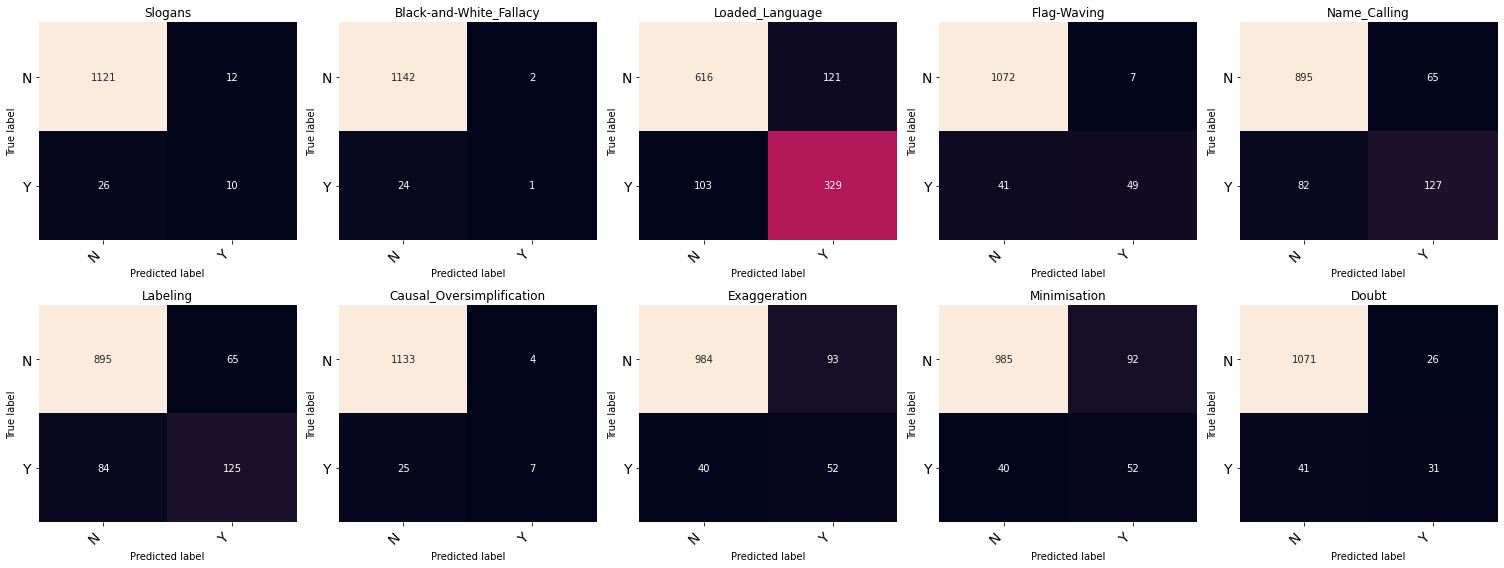

In [ ]:
gold_list = targets
preds_list = outputs

labels =['Slogans','Black-and-White_Fallacy','Loaded_Language','Flag-Waving',
         'Name_Calling','Labeling','Causal_Oversimplification','Exaggeration',
         'Minimisation','Doubt','Appeal_to_Authority',
         'Appeal_to_fear-prejudice',]
report = metrics.classification_report(gold_list, preds_list, target_names=labels,zero_division=0,digits=4)
cm = metrics.multilabel_confusion_matrix(gold_list, preds_list)
accuracy = metrics.accuracy_score(gold_list, preds_list)
print("model name: ",config['MODEL_ID'], '\nArabert_Prep:',config['ArabertPreprocessor'],"\nAccuracy: ", accuracy)

print()
print(report)

rp_dict = metrics.classification_report(gold_list, preds_list, target_names=labels,zero_division=0, output_dict=True)
config['report'] = rp_dict

fig, ax = plt.subplots(2, 5, figsize=(21, 8))
for axes, cmi, label in zip(ax.flatten(), cm, labels):
    print_confusion_matrix(cmi, axes, label, ["N", "Y"])
fig.tight_layout()
plt.show()
fig.savefig("/content/drive/MyDrive/Grad/Grad Proj 2/Arabic_Prop/output.png")